In [2]:
from utils import *
print_version()
cfg = load_config('default')
random_seed = cfg['random_seed']
tf.random.set_seed(cfg['tf_seed'])
np.random.seed(cfg['np_seed'])
data_x, data_y = load_credit_card_dataset()
scaled_x = standard_scale(data_x)

test_split_clm = load_config("supervised.test_split")
x_train_original, x_test, y_train_original, y_test = train_test_split(scaled_x, data_y, stratify=data_y, **test_split_clm)

python:      3.10.11 (text: 3.6)
sklearn:     1.2.2
tensorflow:  2.13.0-rc0 (text: 1.14)
keras:       2.13.1rc0
numpy:       1.24.3
pandas:      1.5.3


In [3]:
print(f"正常ラベル：{np.sum(y_train_original == 0)}，不正ラベル：{np.sum(y_train_original == 1)}")

正常ラベル：190490，不正ラベル：330


## 教師あり機械学習
### データを削減をしなかった場合と，90％削減した場合で比較する．

In [4]:
# データを削減しなかった場合
x_train = x_train_original.copy()
y_train = y_train_original.copy()


# k分割交差検証
k_fold_prm = load_config('supervised.k_fold')
#　k-foldは，`StratifiedKFold`　を使用しているため，y_trainのラベル分布が近くなるように分割する．
k_fold = StratifiedKFold(**k_fold_prm)
predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train.index, columns=['prediction']
)
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア

# x_trainの値の分布を考慮せずに分割して欲しいため，0埋めした配列を`split()`の引数にいれ，そのランダムなインデックスのリストを取得する．
for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_validation_fold = x_train.iloc[train_idx, :], x_train.iloc[validation_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train.iloc[train_idx], y_train.iloc[validation_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    lgb_params = load_config('supervised.lgb')
    gbm = lgb.train(lgb_params, lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(200)]
                    )

    y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_predict)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)


    # print(f"training log loss:  {training_score}")
    # print(f"validation log loss: {validation_score}")
    training_scores.append(training_score)
    validation_scores.append(validation_score)

/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00301121


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00319996


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00249721


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00282048


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00403243


In [5]:
log_loss_light_gbm_gradient_boosting = log_loss(y_train, predictions_based_on_k_folds.loc[:, 'prediction'])
print(f'Light GBM Gradient Boosting Log loss: {log_loss_light_gbm_gradient_boosting}')

Light GBM Gradient Boosting Log loss: 0.0031122592379100237


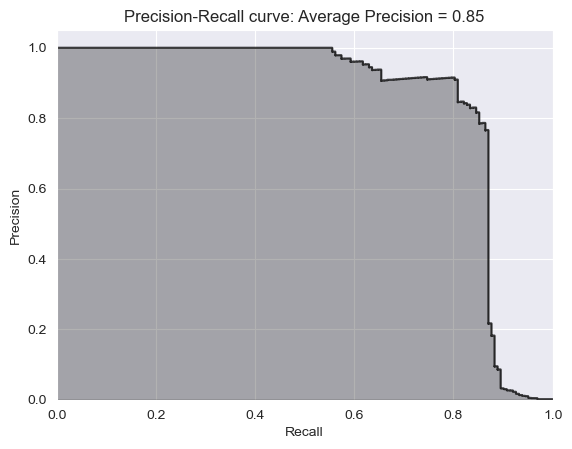

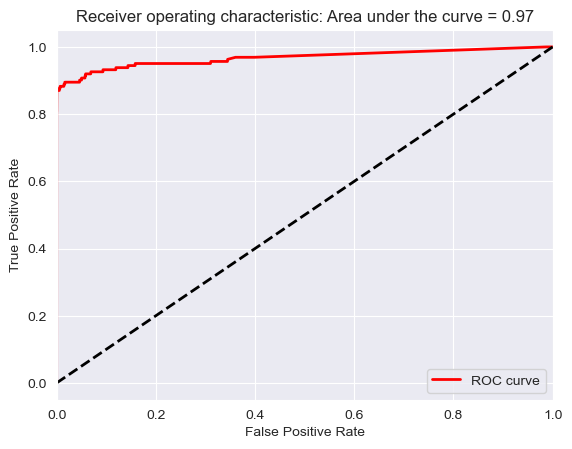

In [6]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(x_test,
                                         num_iteration=gbm.best_iteration), index=x_test.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [7]:
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.9104


In [8]:
del x_train
del y_train
del x_train_fold
del y_train_fold
del y_validation_predict

## データを削減しなかった場合
### テストデータセットにおける適合率75％における再現率は91%

In [9]:
# 訓練セットの90％をDrop
x_train = x_train_original.copy()
y_train = y_train_original.copy()
drop_idx = y_train[y_train==1].sample(frac=0.90, random_state=random_seed).index
x_train.drop(labels=drop_idx, inplace=True)
y_train.drop(labels=drop_idx, inplace=True)


In [10]:
# k分割交差検証
k_fold_prm = load_config('supervised.k_fold')
#　k-foldは，`StratifiedKFold`　を使用しているため，y_trainのラベル分布が近くなるように分割する．
k_fold = StratifiedKFold(**k_fold_prm)
predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train.index, columns=['prediction']
)
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア

# x_trainの値の分布を考慮せずに分割して欲しいため，0埋めした配列を`split()`の引数にいれ，そのランダムなインデックスのリストを取得する．
for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_validation_fold = x_train.iloc[train_idx, :], x_train.iloc[validation_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train.iloc[train_idx], y_train.iloc[validation_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    lgb_params = load_config('supervised.lgb')
    gbm = lgb.train(lgb_params, lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(200)]
                    )

    y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_predict)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)


    print(f"training log loss:  {training_score}")
    print(f"validation log loss: {validation_score}")
    training_scores.append(training_score)
    validation_scores.append(validation_score)

/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.00328814
training log loss:  0.002931231218128015
validation log loss: 0.0032881388005420696


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.002832
training log loss:  0.002783470999943539
validation log loss: 0.0028320009917654106


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00262917
training log loss:  6.042001725578315e-05
validation log loss: 0.002629169106825082


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00220288
training log loss:  7.958947525207722e-05
validation log loss: 0.0022028817657859107


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00269113
training log loss:  0.00012305377324847534
validation log loss: 0.0026911288799465506


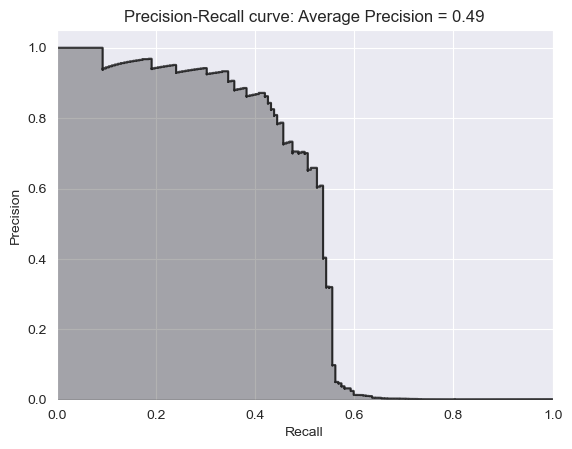

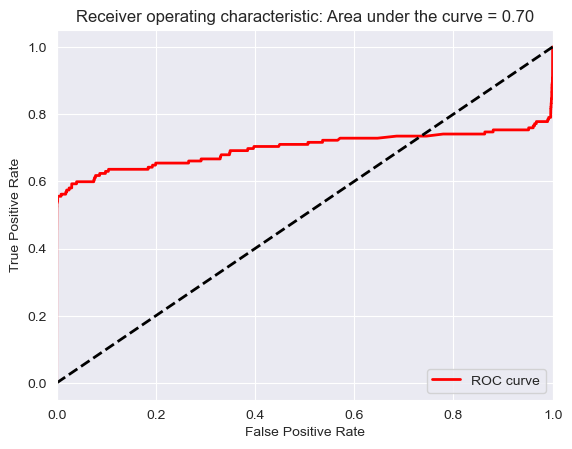

In [11]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(x_test,
                                         num_iteration=gbm.best_iteration), index=x_test.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [12]:
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0015


In [13]:
del x_train
del y_train
del x_train_fold
del y_train_fold
del y_validation_predict

## データを90％削減した場合
### テストデータセットにおける適合率75％における再現率は0．15%

## 教師なし機械学習-1
### 順番に一部の条件を変えながら，最適な設定を探す．
- ### 2層のオートエンコーダ
- ### 隠れ層は，40とする．（過完備オートエンコーダ）
- ### L1正則化を含める．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含める．
- ### 不正ラベルの90％を削除する．
- ### 不正ラベルを100倍に複製する．
- ### 不正ラベルも含める．

In [14]:
# 9.3 教師なしモデル
over_sample_multiplier: int = 100
x_train = x_train_original.copy()
y_train = y_train_original.copy()
drop_idx = y_train[y_train==1].sample(frac=0.90, random_state=random_seed).index
x_train.drop(labels=drop_idx, inplace=True)
y_train.drop(labels=drop_idx, inplace=True)
x_train = x_train.append([x_train[y_train_original==1]] * over_sample_multiplier, ignore_index=False)
y_train = y_train.append([y_train[y_train_original==1]] * over_sample_multiplier, ignore_index=False)
# View shape
x_train.shape, y_train.shape, y_train[y_train == 1].shape

/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_38130/2401478420.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train = x_train.append([x_train[y_train_original==1]] * over_sample_multiplier, ignore_index=False)
/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_38130/2401478420.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train = x_train.append([x_train[y_train_original==1]] * over_sample_multiplier, ignore_index=False)
/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_38130/2401478420.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append([y_train[y_train_original==1]] * over_sample_multiplier, ignore_index=False)


((193823, 29), (193823,), (3333,))

In [15]:
model_1 = keras.Sequential([
    Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29, name='hidden_layer'),
    Dropout(0.02),
    Dense(units=29, activation='linear')
])

Epoch 1/5
4846/4846 [==============================] - 2s 477us/step - loss: 0.0967 - accuracy: 0.8470 - val_loss: 0.0070 - val_accuracy: 0.9852
Epoch 2/5
4846/4846 [==============================] - 2s 459us/step - loss: 0.0189 - accuracy: 0.9263 - val_loss: 0.0371 - val_accuracy: 0.9758
Epoch 3/5
4846/4846 [==============================] - 2s 460us/step - loss: 0.0173 - accuracy: 0.9281 - val_loss: 0.0368 - val_accuracy: 0.9809
Epoch 4/5
4846/4846 [==============================] - 2s 461us/step - loss: 0.0172 - accuracy: 0.9271 - val_loss: 0.0265 - val_accuracy: 0.9823
Epoch 5/5
2938/2938 [==============================] - 1s 243us/step


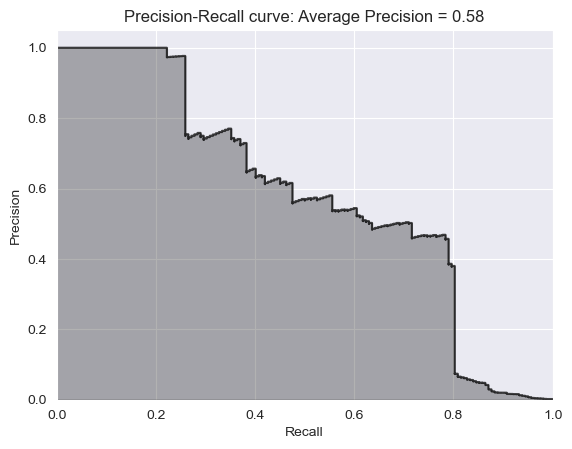

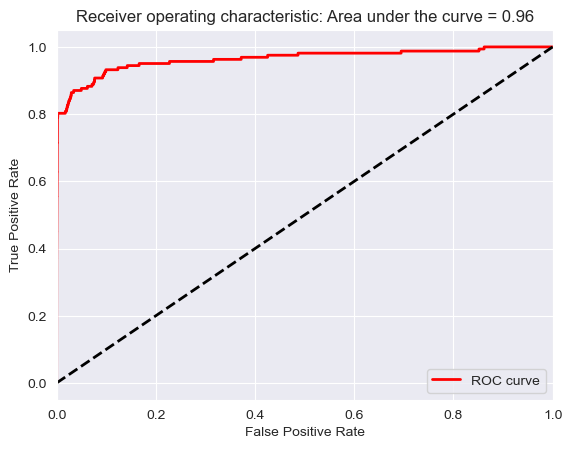

Precision at 75% recall 0.4656


In [16]:
compile_prm = load_config('unsupervised.compile')
model_1.compile(**compile_prm)
fit_prm = load_config('unsupervised.fit')
model_1.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_1.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-2
- ### 2層のオートエンコーダ
- ### 隠れ層は，20とする．（未完備オートエンコーダ）
- ### L1正則化を含めない．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含めない．
- ### 不正ラベルの90％を削除する．
- ### 不正ラベルを100倍に複製する．
- ### 不正ラベルも含める．

In [17]:
model_2 = keras.Sequential([
    Dense(units=20, activation='linear',  input_dim=29, name='hidden_layer'),
    Dense(units=29, activation='linear')
])

Epoch 1/5
4846/4846 [==============================] - 3s 560us/step - loss: 0.3427 - accuracy: 0.5465 - val_loss: 2.1199 - val_accuracy: 0.5685
Epoch 2/5
4846/4846 [==============================] - 2s 439us/step - loss: 0.2571 - accuracy: 0.6097 - val_loss: 2.2059 - val_accuracy: 0.5624
Epoch 3/5
4846/4846 [==============================] - 3s 592us/step - loss: 0.2553 - accuracy: 0.5992 - val_loss: 2.2165 - val_accuracy: 0.5808
Epoch 4/5
4846/4846 [==============================] - 2s 435us/step - loss: 0.2525 - accuracy: 0.6172 - val_loss: 2.2619 - val_accuracy: 0.6017
Epoch 5/5
2938/2938 [==============================] - 1s 233us/step


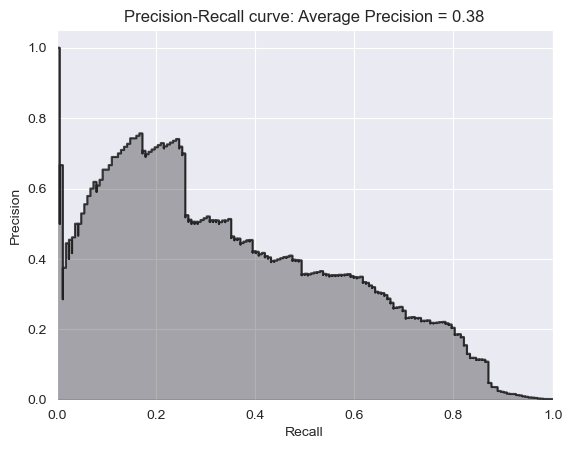

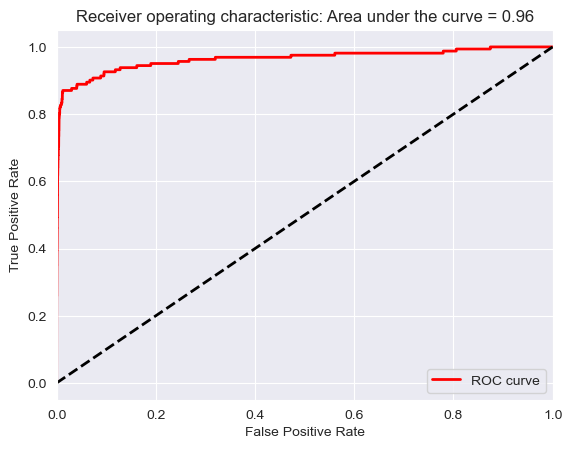

Precision at 75% recall 0.2255


In [18]:
model_2.compile(**compile_prm)
model_2.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_2.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-3
- ### 3層のオートエンコーダ
- ### 隠れ層は，20とする．（未完備オートエンコーダ）
- ### L1正則化を含めない．
- ### 活性化関数は，ReLU関数を用いる．
- ### 2％のドロップアウトを含めない．
- ### 不正ラベルの90％を削除する．
- ### 不正ラベルを100倍に複製する．
- ### 不正ラベルも含める．

In [19]:
model_3 = keras.Sequential([
    Dense(units=20, activation='relu',  input_dim=29, name='hidden_layer'),
    Dense(units=20, activation='relu'),
    Dense(units=29, activation='linear')
])

Epoch 1/5
4846/4846 [==============================] - 3s 504us/step - loss: 0.3977 - accuracy: 0.4896 - val_loss: 2.2248 - val_accuracy: 0.5414
Epoch 2/5
4846/4846 [==============================] - 2s 494us/step - loss: 0.2953 - accuracy: 0.5797 - val_loss: 2.2350 - val_accuracy: 0.5522
Epoch 3/5
4846/4846 [==============================] - 2s 514us/step - loss: 0.2939 - accuracy: 0.5841 - val_loss: 2.2347 - val_accuracy: 0.5458
Epoch 4/5
4846/4846 [==============================] - 2s 492us/step - loss: 0.2917 - accuracy: 0.5860 - val_loss: 2.2428 - val_accuracy: 0.5521
Epoch 5/5
2938/2938 [==============================] - 1s 238us/step


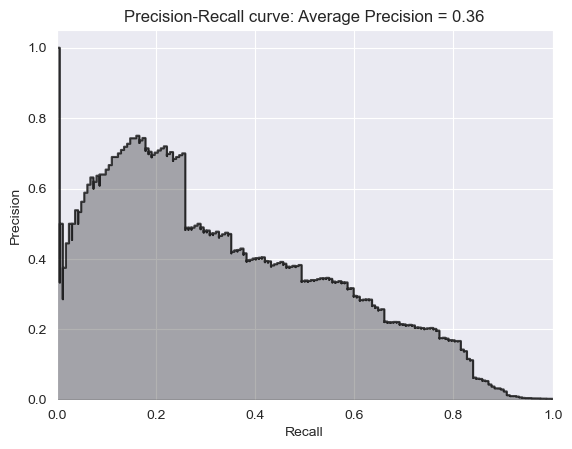

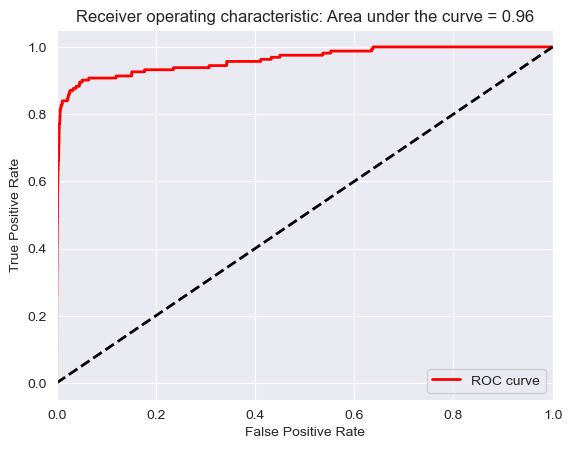

Precision at 75% recall 0.203


In [20]:
model_3.compile(**compile_prm)
model_3.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_3.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-4
- ### 3層のオートエンコーダ
- ### 隠れ層は，40とする．（過完備オートエンコーダ）
- ### L1正則化を含める．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含める．
- ### 不正ラベルの90％を削除する．
- ### 不正ラベルを100倍に複製する．
- ### 不正ラベルも含める．

In [ ]:
model_4 = keras.Sequential([
    Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29, name='hidden_layer'),
    Dropout(0.02),
    Dense(units=40, activation='linear'),
    Dense(units=29, activation='linear')
])

In [ ]:
model_4.compile(**compile_prm)
model_4.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_4.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-5
- ### 教師なし機械学習-1と同じ条件
- ### 2層のオートエンコーダ
- ### 隠れ層は，40とする．（過完備オートエンコーダ）
- ### L1正則化を含める．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含める．
- ### 不正ラベルを含めない

In [23]:
x_train = x_train[y_train == 0]
y_train = y_train[y_train == 0]

Epoch 1/5
4763/4763 [==============================] - 2s 495us/step - loss: 0.0167 - accuracy: 0.9279 - val_loss: 0.0031 - val_accuracy: 0.9851
Epoch 2/5
4763/4763 [==============================] - 2s 478us/step - loss: 0.0175 - accuracy: 0.9278 - val_loss: 0.0035 - val_accuracy: 0.9845
Epoch 3/5
4763/4763 [==============================] - 2s 516us/step - loss: 0.0175 - accuracy: 0.9281 - val_loss: 0.0026 - val_accuracy: 0.9878
Epoch 4/5
4763/4763 [==============================] - 2s 481us/step - loss: 0.0165 - accuracy: 0.9275 - val_loss: 0.0023 - val_accuracy: 0.9871
Epoch 5/5
2938/2938 [==============================] - 1s 235us/step


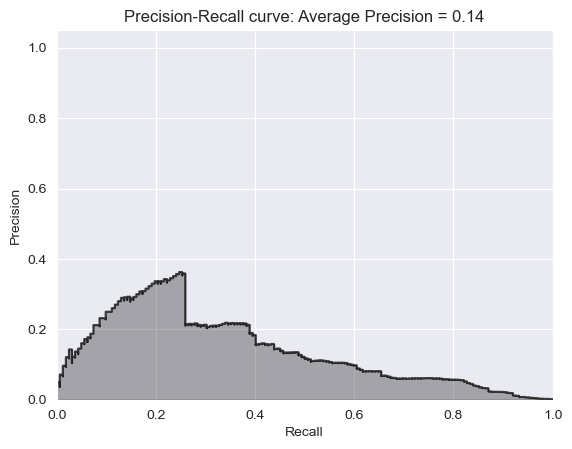

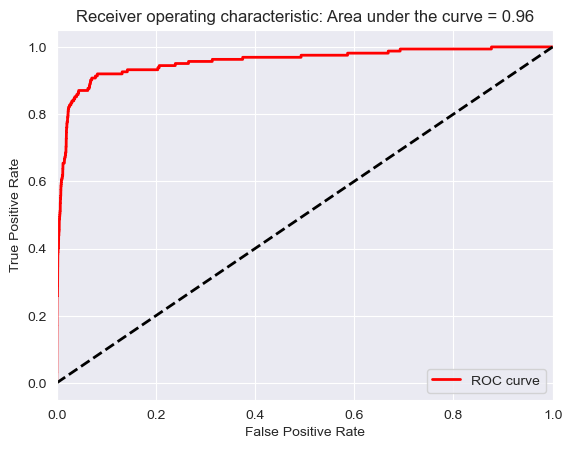

Precision at 75% recall 0.0617


In [24]:
model_5 = keras.Sequential(model_1.layers.copy())
model_5.compile(**compile_prm)
model_5.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_1.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-6
- ### ## 教師なし機械学習-2
- ### 2層のオートエンコーダ
- ### 隠れ層は，20とする．（未完備オートエンコーダ）
- ### L1正則化を含めない．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含めない．
- ### 不正ラベルを含めない

Epoch 1/5
4763/4763 [==============================] - 3s 524us/step - loss: 0.2482 - accuracy: 0.6522 - val_loss: 0.2405 - val_accuracy: 0.6475
Epoch 2/5
4763/4763 [==============================] - 2s 439us/step - loss: 0.2483 - accuracy: 0.6588 - val_loss: 0.2401 - val_accuracy: 0.6621
Epoch 3/5
4763/4763 [==============================] - 2s 459us/step - loss: 0.2472 - accuracy: 0.6630 - val_loss: 0.2409 - val_accuracy: 0.6598
Epoch 4/5
4763/4763 [==============================] - 2s 452us/step - loss: 0.2473 - accuracy: 0.6682 - val_loss: 0.2398 - val_accuracy: 0.6621
Epoch 5/5
2938/2938 [==============================] - 1s 235us/step


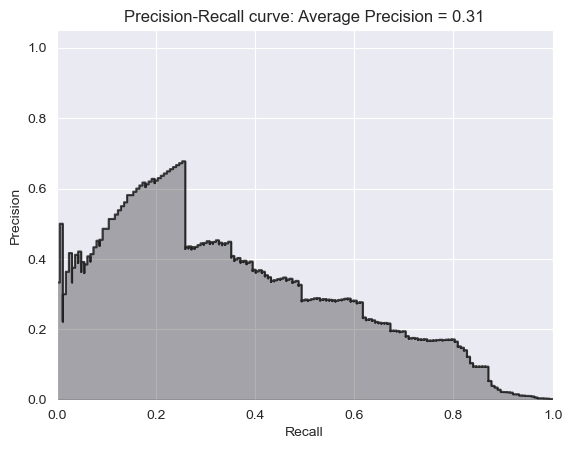

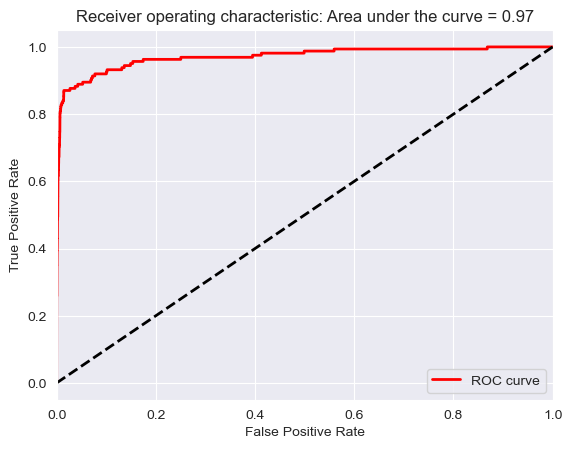

Precision at 75% recall 0.1678


In [25]:
model_6 = keras.Sequential(model_2.layers.copy())
model_6.compile(**compile_prm)
model_6.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_6.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-7
- ### 教師なし機械学習-3と同じ条件
- ### 4層のオートエンコーダ
- ### 隠れ層は，20とする．（未完備オートエンコーダ）
- ### L1正則化を含めない．
- ### 活性化関数は，線形活性化関数を用いる．
- ### 2％のドロップアウトを含めない．
- ### 不正ラベルを含めない

Epoch 1/5
4763/4763 [==============================] - 3s 523us/step - loss: 0.2864 - accuracy: 0.5982 - val_loss: 0.2781 - val_accuracy: 0.5935
Epoch 2/5
4763/4763 [==============================] - 3s 529us/step - loss: 0.2869 - accuracy: 0.6009 - val_loss: 0.2774 - val_accuracy: 0.5982
Epoch 3/5
4763/4763 [==============================] - 2s 500us/step - loss: 0.2853 - accuracy: 0.5979 - val_loss: 0.2786 - val_accuracy: 0.6082
Epoch 4/5
4763/4763 [==============================] - 2s 511us/step - loss: 0.2855 - accuracy: 0.6147 - val_loss: 0.2756 - val_accuracy: 0.6161
Epoch 5/5
2938/2938 [==============================] - 1s 246us/step


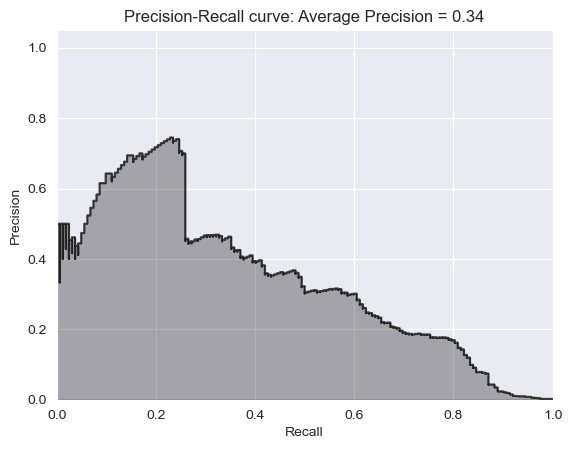

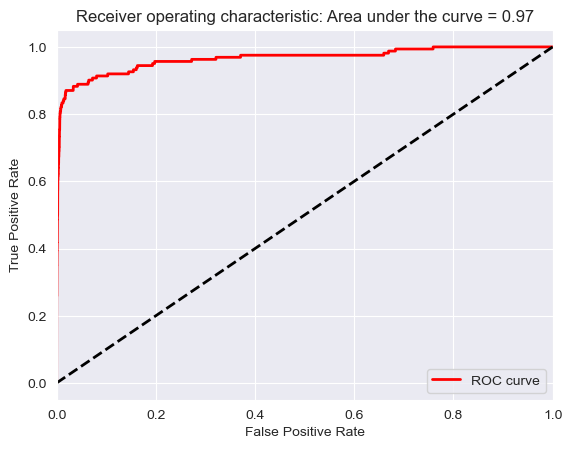

Precision at 75% recall 0.1854


In [26]:
model_7 = keras.Sequential(model_3.layers.copy())
model_7.compile(**compile_prm)
model_7.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_7.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 教師なし機械学習-8
- ### 教師なし機械学習-4と同じ条件
- ### 3層のオートエンコーダ
- ### 隠れ層は，20とする．（未完備オートエンコーダ）
- ### L1正則化を含めない．
- ### 活性化関数は，ReLU関数を用いる．
- ### 2％のドロップアウトを含めない．
- ### 不正ラベルを含めない

Epoch 1/5
4763/4763 [==============================] - 3s 557us/step - loss: 0.5565 - accuracy: 0.7894 - val_loss: 0.5416 - val_accuracy: 0.8240
Epoch 2/5
4763/4763 [==============================] - 3s 605us/step - loss: 0.5571 - accuracy: 0.7887 - val_loss: 0.5419 - val_accuracy: 0.8248
Epoch 3/5
4763/4763 [==============================] - 3s 539us/step - loss: 0.5568 - accuracy: 0.7893 - val_loss: 0.5416 - val_accuracy: 0.8326
Epoch 4/5
4763/4763 [==============================] - 3s 559us/step - loss: 0.5567 - accuracy: 0.7908 - val_loss: 0.5417 - val_accuracy: 0.8319
Epoch 5/5
2938/2938 [==============================] - 1s 243us/step


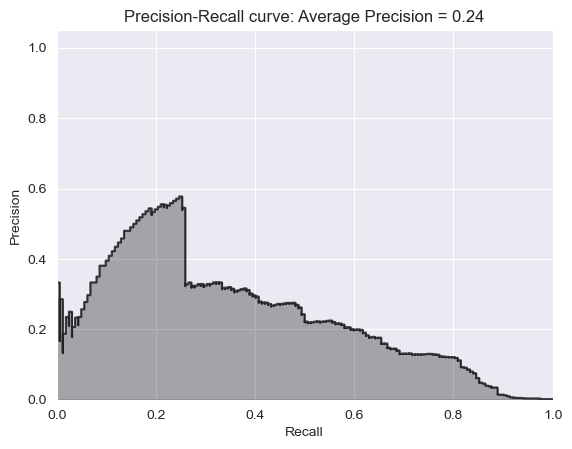

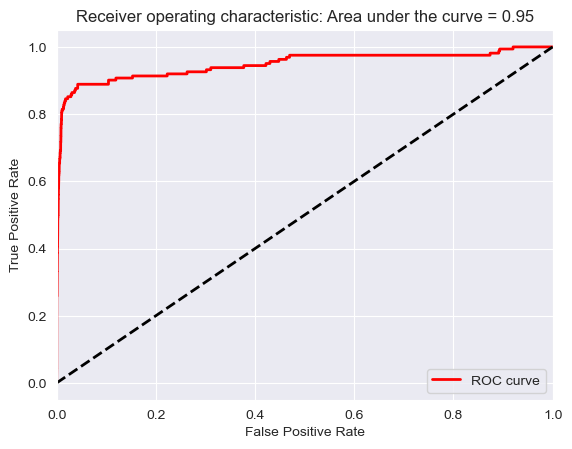

Precision at 75% recall 0.1305


In [27]:
model_8 = keras.Sequential(model_4.layers.copy())
model_8.compile(**compile_prm)
model_8.fit(x=x_train, y=x_train, **fit_prm)
predictions_test = model_8.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions_test)
preds, _ = plot_results(y_test, anomaly_scores_ae, True)
# Calculate precision at 75% recall
_, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision, 4)}')

## 各教師なしモデルのhidden layerを半教師あり学習の出力層に用いる

In [28]:
unsupervised_models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
x_test_original = x_test.copy()
cnt = 1
for unsupervised_model in unsupervised_models:
    unsupervised_model.summary()
    model = keras.Model(inputs=unsupervised_model.input,
                outputs=unsupervised_model.get_layer("hidden_layer").output)
    intermediate_train_pred = model.predict(x_train)
    intermediate_test_pred = model.predict(x_test)
    intermediate_train_df = pd.DataFrame(data=intermediate_train_pred, index=x_train.index)
    intermediate_test_df = pd.DataFrame(data=intermediate_test_pred, index=x_test.index)
    x_train = x_train_original.copy()
    if cnt < 5:
        x_train = x_train[y_train == 0]
    x_train = x_train.merge(intermediate_train_df, left_index=True, right_index=True)
    x_test = x_test_original.copy().merge(intermediate_test_df, left_index=True, right_index=True)
    y_train = y_train_original.copy()

    # 学習
    training_scores = [] # 学習率
    validation_scores = [] # 検証スコア

    predictions_based_on_k_folds = pd.DataFrame(
        data=[], index=y_train.index, columns=['prediction']
    )
    print(x_train.shape, y_train.shape)
    for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
        x_train_fold, x_validation_fold = x_train.iloc[train_idx, :], x_train.iloc[validation_idx, :] # 2次元配列
        y_train_fold, y_validation_fold = y_train.iloc[train_idx], y_train.iloc[validation_idx] # １次元配列

        lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
        lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
        lgb_params = load_config('supervised.lgb')
        gbm = lgb.train(lgb_params, lgb_train,
                        num_boost_round=2000,
                        valid_sets=lgb_eval,
                        callbacks=[lgb.early_stopping(200)]
                        )

        y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
        training_score = log_loss(y_train_fold, y_train_predict)

        y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
        predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
        validation_score = log_loss(y_validation_fold, y_validation_predict)

        training_scores.append(training_score)
        validation_scores.append(validation_score)
        # Print results
    log_loss_light_gbm_gradient_boosting = log_loss(y_train, predictions_based_on_k_folds.loc[:,'prediction'])
    # print(f'LightGBM Gradient Boosting Log Loss: {round(log_loss_light_gbm_gradient_boosting, 4)}')
    # Evaluate results on test set
    predictions = pd.Series(data=gbm.predict(x_test, num_iteration=gbm.best_iteration),index=x_test.index)
    preds, _ = plot_results(y_test, predictions, True)
    # Calculate precision at 75% recall
    _, precision = precision_analysis(preds, "anomaly_score", 0.75)
    model.summary()
    print(f'model{cnt}: Precision at 75% recall {round(precision, 4)}')
    cnt += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 40)                1200      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 29)                1189      
                                                                 
Total params: 2389 (9.33 KB)
Trainable params: 2389 (9.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2938/2938 [==============================] - 1s 230us/step


/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_38130/3926729395.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_train = x_train[y_train == 0]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
x_train_original[y_train_original == 0].shape